
   #  Normal Score Transform in Python for Engineers and Geoscientists 

## with GSLIB's DECLUS Program Converted to Python

### Michael Pyrcz, Associate Professor, University of Texas at Austin 


#### Contacts: [Twitter/@GeostatsGuy](https://twitter.com/geostatsguy) | [GitHub/GeostatsGuy](https://github.com/GeostatsGuy) | [www.michaelpyrcz.com](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446)

This is a tutorial for / demonstration of **Normal Score Transform / Gaussian Anamorphosis in Python with GSLIB's NSCORE program translated to Python, wrappers and reimplementations of other GSLIB: Geostatistical Library methods** (Deutsch and Journel, 1997). 

This exercise demonstrates the noraml score transform method in Python with wrappers and reimplimentation of GSLIB methods.  The steps include:

1. general a random dataset
2. transform to Gaussian
3. visualize initial and transformed distributions
4. visualize the cross plot of the transform table (q-q plot)

To accomplish this I have provide wrappers or reimplementation in Python for the following GSLIB methods:

1. sgsim - sequantial Gaussian simulation limited to 2D and unconditional
2. hist - histograms plots reimplemented with GSLIB parameters using python methods
3. locmap - location maps reimplemented with GSLIB parameters using python methods
4. pixelplt - pixel plots reimplemented with GSLIB parameters using python methods
5. locpix - my modification of GSLIB to superimpose a location map on a pixel plot reimplemented with GSLIB parameters using Python methods
5. affine - affine correction adjust the mean and standard deviation of a feature reimplemented with GSLIB parameters using Python methods

I have also started to translate the GSLIB support subfunctions to Python.

The GSLIB source and executables are available at http://www.statios.com/Quick/gslib.html.  For the reference on using GSLIB check out the User Guide, GSLIB: Geostatistical Software Library and User's Guide by Clayton V. Deutsch and Andre G. Journel.

I did this to allow people to use these GSLIB functions that are extremely robust in Python. Also this should be a bridge to allow so many familar with GSLIB to work in Python as a kept the parameterization and displays consistent with GSLIB.  The wrappers are simple functions declared below that write the parameter files, run the GSLIB executable in the working directory and load and visualize the output in Python. This will be included on GitHub for anyone to try it out https://github.com/GeostatsGuy/.  

This was my first effort to translate the GSLIB Fortran to Python.  It was pretty easy so I'll start translating other critical GSLIB functions.

#### Load the required libraries

The following code loads the required libraries.

In [216]:
import os                                                 # to set current working directory 
import numpy as np                                        # arrays and matrix math
import pandas as pd                                       # DataFrames
import matplotlib.pyplot as plt                           # plotting

If you get a package import error, you may have to first install some of these packages. This can usually be accomplished by opening up a command window on Windows and then typing 'python -m pip install [package-name]'. More assistance is available with the respective package docs.  

#### Declare functions

Here are the wrappers and reimplementations of GSLIB method along with two utilities to load GSLIB's Geo-EAS from data files into DataFrames and 2D Numpy arrays.

In [217]:
# Some GeostatsPy Functions - by Michael Pyrcz, maintained at https://git.io/fNgR7.
# A set of functions to provide access to GSLIB in Python.
# GSLIB executables: nscore.exe, declus.exe, gam.exe, gamv.exe, vmodel.exe, kb2d.exe & sgsim.exe must be in the working directory 
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt                          
import random as rand
image_type = 'tif'; dpi = 600

# utility to convert GSLIB Geo-EAS files to a 1D or 2D numpy ndarray for use with Python methods
def GSLIB2ndarray(data_file,kcol,nx,ny): 
    colArray = []
    if ny > 1:
        array = np.ndarray(shape=(ny,nx),dtype=float,order='F')
    else:
        array = np.zeros(nx)    
    with open(data_file) as myfile:   # read first two lines
        head = [next(myfile) for x in range(2)]
        line2 = head[1].split()
        ncol = int(line2[0])          # get the number of columns
        for icol in range(0, ncol):   # read over the column names
            head = [next(myfile) for x in range(1)]
            if icol == kcol:
                col_name = head[0].split()[0]       
        if ny > 1:
            for iy in range(0,ny):
                for ix in range(0,nx):
                    head = [next(myfile) for x in range(1)]
                    array[ny-1-iy][ix] = head[0].split()[kcol]
        else:
            for ix in range(0,nx):
                head = [next(myfile) for x in range(1)]
                array[ix] = head[0].split()[kcol]
    return array,col_name 

# utility to convert GSLIB Geo-EAS files to a pandas DataFrame for use with Python methods
def GSLIB2Dataframe(data_file):
    colArray = []
    with open(data_file) as myfile:   # read first two lines
        head = [next(myfile) for x in range(2)]
        line2 = head[1].split()
        ncol = int(line2[0])
        for icol in range(0, ncol):
            head = [next(myfile) for x in range(1)]
            colArray.append(head[0].split()[0])
        data = np.loadtxt(myfile, skiprows = 0)
        df = pd.DataFrame(data)
        df.columns = colArray
        return df

# histogram, reimplemented in Python of GSLIB hist with MatPlotLib methods, displayed and as image file
def hist(array,xmin,xmax,log,cumul,bins,weights,xlabel,title,fig_name):
    plt.figure(figsize=(8,6))
    cs = plt.hist(array, alpha = 0.2, color = 'red', edgecolor = 'black', bins=bins, range = [xmin,xmax], weights = weights, log = log, cumulative = cumul)
    plt.title(title)
    plt.xlabel(xlabel); plt.ylabel('Frequency')  
    plt.savefig(fig_name + '.' + image_type,dpi=dpi)
    plt.show()
    return

# histogram, reimplemented in Python of GSLIB hist with MatPlotLib methods (version for subplots)
def hist_st(array,xmin,xmax,log,cumul,bins,weights,xlabel,title):  
    cs = plt.hist(array, alpha = 0.2, color = 'red', edgecolor = 'black', bins=bins, range = [xmin,xmax], weights = weights, log = log, cumulative = cumul)
    plt.title(title)
    plt.xlabel(xlabel); plt.ylabel('Frequency') 
    return

# location map, reimplemention in Python of GSLIB locmap with MatPlotLib methods
def locmap(df,xcol,ycol,vcol,xmin,xmax,ymin,ymax,vmin,vmax,title,xlabel,ylabel,vlabel,cmap,fig_name):
    ixy = 0 
    plt.figure(figsize=(8,6))    
    im = plt.scatter(df[xcol],df[ycol],s=None, c=df[vcol], marker=None, cmap=cmap, norm=None, vmin=vmin, vmax=vmax, alpha=0.8, linewidths=0.8, verts=None, edgecolors="black")
    plt.title(title)
    plt.xlim(xmin,xmax)
    plt.ylim(ymin,ymax)    
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    cbar = plt.colorbar(im, orientation = 'vertical',ticks=np.linspace(vmin,vmax,10))
    cbar.set_label(vlabel, rotation=270, labelpad=20)
    plt.savefig(fig_name + '.' + image_type,dpi=dpi)
    plt.show()
    return im

# location map, reimplemention in Python of GSLIB locmap with MatPlotLib methods (version for subplots)
def locmap_st(df,xcol,ycol,vcol,xmin,xmax,ymin,ymax,vmin,vmax,title,xlabel,ylabel,vlabel,cmap):
    ixy = 0   
    im = plt.scatter(df[xcol],df[ycol],s=None, c=df[vcol], marker=None, cmap=cmap, norm=None, vmin=vmin, vmax=vmax, alpha=0.8, linewidths=0.8, verts=None, edgecolors="black")
    plt.title(title)
    plt.xlim(xmin,xmax)
    plt.ylim(ymin,ymax)    
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    cbar = plt.colorbar(im, orientation = 'vertical',ticks=np.linspace(vmin,vmax,10))
    cbar.set_label(vlabel, rotation=270, labelpad=20)
    return im           

# pixel plot, reimplemention in Python of GSLIB pixelplt with MatPlotLib methods
def pixelplt(array,xmin,xmax,ymin,ymax,step,vmin,vmax,title,xlabel,ylabel,vlabel,cmap,fig_name):
    print(str(step))
    xx, yy = np.meshgrid(np.arange(xmin, xmax, step),np.arange(ymax, ymin, -1*step))
    plt.figure(figsize=(8,6))
    im = plt.contourf(xx,yy,array,cmap=cmap,vmin=vmin,vmax=vmax,levels=np.linspace(vmin,vmax,100))
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    cbar = plt.colorbar(im,orientation = 'vertical',ticks=np.linspace(vmin,vmax,10))
    cbar.set_label(vlabel, rotation=270, labelpad=20)
    plt.savefig(fig_name + '.' + image_type,dpi=dpi)
    plt.show()
    return im

# pixel plot, reimplemention in Python of GSLIB pixelplt with MatPlotLib methods(version for subplots)
def pixelplt_st(array,xmin,xmax,ymin,ymax,step,vmin,vmax,title,xlabel,ylabel,vlabel,cmap):
    xx, yy = np.meshgrid(np.arange(xmin, xmax, step),np.arange(ymax, ymin, -1*step))
    ixy = 0 
    x = [];y = []; v = [] # use dummy since scatter plot controls legend min and max appropriately and contour does not!
    cs = plt.contourf(xx,yy,array,cmap=cmap,vmin=vmin,vmax=vmax,levels = np.linspace(vmin,vmax,100))
    im = plt.scatter(x,y,s=None, c=v, marker=None,cmap=cmap, vmin=vmin, vmax=vmax, alpha=0.8, linewidths=0.8, verts=None, edgecolors="black")
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.clim(vmin,vmax)
    cbar = plt.colorbar(im, orientation = 'vertical')
    cbar.set_label(vlabel, rotation=270, labelpad=20)
    return cs

# pixel plot and location map, reimplementation in Python of a GSLIB MOD with MatPlotLib methods
def locpix(array,xmin,xmax,ymin,ymax,step,vmin,vmax,df,xcol,ycol,vcol,title,xlabel,ylabel,vlabel,cmap,fig_name):
    xx, yy = np.meshgrid(np.arange(xmin, xmax, step),np.arange(ymax, ymin, -1*step))
    ixy = 0 
    plt.figure(figsize=(8,6))
    cs = plt.contourf(xx, yy, array, cmap=cmap,vmin=vmin, vmax=vmax,levels = np.linspace(vmin,vmax,100))
    im = plt.scatter(df[xcol],df[ycol],s=None, c=df[vcol], marker=None, cmap=cmap, vmin=vmin, vmax=vmax, alpha=0.8, linewidths=0.8, verts=None, edgecolors="black")
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xlim(xmin,xmax)
    plt.ylim(ymin,ymax)  
    cbar = plt.colorbar(orientation = 'vertical')
    cbar.set_label(vlabel, rotation=270, labelpad=20)
    plt.savefig(fig_name + '.' + image_type,dpi=dpi)
    plt.show()
    return cs

# pixel plot and location map, reimplementation in Python of a GSLIB MOD with MatPlotLib methods(version for subplots)
def locpix_st(array,xmin,xmax,ymin,ymax,step,vmin,vmax,df,xcol,ycol,vcol,title,xlabel,ylabel,vlabel,cmap):
    xx, yy = np.meshgrid(np.arange(xmin, xmax, step),np.arange(ymax, ymin, -1*step))
    ixy = 0 
    cs = plt.contourf(xx, yy, array, cmap=cmap,vmin=vmin, vmax=vmax,levels = np.linspace(vmin,vmax,100))
    im = plt.scatter(df[xcol],df[ycol],s=None, c=df[vcol], marker=None, cmap=cmap, vmin=vmin, vmax=vmax, alpha=0.8, linewidths=0.8, verts=None, edgecolors="black")
    plt.title(title)
    plt.xlabel(xlabel)  
    plt.ylabel(ylabel)
    plt.xlim(xmin,xmax)
    plt.ylim(ymin,ymax)
    cbar = plt.colorbar(orientation = 'vertical')
    cbar.set_label(vlabel, rotation=270, labelpad=20)

# affine distribution correction reimplemented in Python with numpy methods 
def affine(array,tmean,tstdev): 
    mean = np.average(array)
    stdev = np.std(array)  
    array = (tstdev/stdev)*(array - mean) + tmean
    return(array)   

def make_variogram(nug,nst,it1,cc1,azi1,hmaj1,hmin1,it2=1,cc2=0,azi2=0,hmaj2=0,hmin2=0):
    if cc2 == 0:
        nst = 1
    var = dict([('nug', nug), ('nst', nst), ('it1', it1),('cc1', cc1),('azi1', azi1),('hmaj1', hmaj1), ('hmin1', hmin1), 
      ('it2', it2),('cc2', cc2),('azi2', azi2),('hmaj2', hmaj2), ('hmin2', hmin2)])
    if nug + cc1 + cc2 != 1:
        print('\x1b[0;30;41m make_variogram Warning: sill does not sum to 1.0, do not use in simulation \x1b[0m')
    if cc1 < 0 or cc2 < 0 or nug < 0 or hmaj1 < 0 or hmaj2 < 0 or hmin1 < 0 or hmin2 < 0:
        print('\x1b[0;30;41m make_variogram Warning: contributions and ranges must be all positive \x1b[0m')
    if hmaj1 < hmin1 or hmaj2 < hmin2:
        print('\x1b[0;30;41m make_variogram Warning: major range should be greater than minor range \x1b[0m')
    return var
    
# sequential Gaussian simulation, 2D unconditional wrapper for sgsim from GSLIB (.exe must be in working directory)
def GSLIB_sgsim_2d_uncond(nreal,nx,ny,hsiz,seed,var,output_file):
    import os
    import numpy as np 
    
    nug = var['nug']
    nst = var['nst']; it1 = var['it1']; cc1 = var['cc1']; azi1 = var['azi1']; hmaj1 = var['hmaj1']; hmin1 = var['hmin1'] 
    it2 = var['it2']; cc2 = var['cc2']; azi2 = var['azi2']; hmaj2 = var['hmaj2']; hmin2 = var['hmin2']     
    max_range = max(hmaj1,hmaj2) 
    hmn = hsiz * 0.5   
    hctab = int(max_range/hsiz)*2 + 1
    
    sim_array = np.random.rand(nx,ny)
  
    file = open("sgsim.par", "w")
    file.write("              Parameters for SGSIM                                         \n")
    file.write("              ********************                                         \n")
    file.write("                                                                           \n")
    file.write("START OF PARAMETER:                                                        \n")
    file.write("none                          -file with data                              \n")
    file.write("1  2  0  3  5  0              -  columns for X,Y,Z,vr,wt,sec.var.          \n")
    file.write("-1.0e21 1.0e21                -  trimming limits                           \n")
    file.write("0                             -transform the data (0=no, 1=yes)            \n")
    file.write("none.trn                      -  file for output trans table               \n")
    file.write("1                             -  consider ref. dist (0=no, 1=yes)          \n")
    file.write("none.dat                      -  file with ref. dist distribution          \n")
    file.write("1  0                          -  columns for vr and wt                     \n")
    file.write("-4.0    4.0                   -  zmin,zmax(tail extrapolation)             \n")
    file.write("1      -4.0                   -  lower tail option, parameter              \n")
    file.write("1       4.0                   -  upper tail option, parameter              \n")
    file.write("0                             -debugging level: 0,1,2,3                    \n")
    file.write("nonw.dbg                      -file for debugging output                   \n")
    file.write(str(output_file) + "           -file for simulation output                  \n")
    file.write(str(nreal) + "                 -number of realizations to generate          \n")
    file.write(str(nx) + " " + str(hmn) + " " + str(hsiz) + "                              \n")
    file.write(str(ny) + " " + str(hmn) + " " + str(hsiz) + "                              \n")
    file.write("1 0.0 1.0                     - nz zmn zsiz                                \n")
    file.write(str(seed) + "                  -random number seed                          \n")
    file.write("0     8                       -min and max original data for sim           \n")
    file.write("12                            -number of simulated nodes to use            \n")
    file.write("0                             -assign data to nodes (0=no, 1=yes)          \n")
    file.write("1     3                       -multiple grid search (0=no, 1=yes),num      \n")
    file.write("0                             -maximum data per octant (0=not used)        \n")
    file.write(str(max_range) + " " + str(max_range) + " 1.0 -maximum search  (hmax,hmin,vert) \n")
    file.write(str(azi1) + "   0.0   0.0       -angles for search ellipsoid                 \n")
    file.write(str(hctab) + " " + str(hctab) + " 1 -size of covariance lookup table        \n")
    file.write("0     0.60   1.0              -ktype: 0=SK,1=OK,2=LVM,3=EXDR,4=COLC        \n")
    file.write("none.dat                      -  file with LVM, EXDR, or COLC variable     \n")
    file.write("4                             -  column for secondary variable             \n")
    file.write(str(nst) + " " + str(nug) + "  -nst, nugget effect                          \n")
    file.write(str(it1) + " " + str(cc1) + " " +str(azi1) + " 0.0 0.0 -it,cc,ang1,ang2,ang3\n")
    file.write(" " + str(hmaj1) + " " + str(hmin1) + " 1.0 - a_hmax, a_hmin, a_vert        \n")
    file.write(str(it2) + " " + str(cc2) + " " +str(azi2) + " 0.0 0.0 -it,cc,ang1,ang2,ang3\n")
    file.write(" " + str(hmaj2) + " " + str(hmin2) + " 1.0 - a_hmax, a_hmin, a_vert        \n")  
    file.close()

    os.system('"sgsim.exe sgsim.par"')       
    sim_array = GSLIB2ndarray(output_file,0,nx,ny)         
    return(sim_array[0])

# extract regular spaced samples from a model   
def regular_sample(array,xmin,xmax,ymin,ymax,step,mx,my,name):
    x = []; y = []; v = []; iix = 0; iiy = 0;
    xx, yy = np.meshgrid(np.arange(xmin, xmax, step),np.arange(ymax, ymin, -1*step))
    iiy = 0
    for iy in range(0,ny):
        if iiy >= my:
            iix = 0
            for ix in range(0,nx):
                if iix >= mx:
                    x.append(xx[ix,iy]);y.append(yy[ix,iy]); v.append(array[ix,iy])
                    iix = 0; iiy = 0
                iix = iix + 1
        iiy = iiy + 1
    df = pd.DataFrame(np.c_[x,y,v],columns=['X', 'Y', name])
    return(df)

These are a variety of GSLIB sub functions required by the NSCORE function that I have converted to Python.  I will continue to convert the subfunctions and include them as needed by the GSLIB functions that I convert.

In [218]:
def dlocate(xx,iis,iie,x):
    from bisect import bisect
    n = len(xx)
    if iie <= iis:
        iis = 0; ie = n-1
    array = xx[iis:iie-1]  # this is accounting for swith to 0,...,n-1 index
    j = bisect(array,x)
    return j

def dsortem(ib,ie,a,iperm,b=0,c=0,d=0,e=0,f=0,g=0,h=0):
    a = a[ib:ie]
    inds = a.argsort()
    a = np.copy(a[inds]) # deepcopy forces pass to outside scope
    if(iperm == 1):
        return a
    b_slice = b[ib:ie]
    b = b_slice[inds]    
    if iperm == 2:
        return a,b
    c_slice = c[ib:ie]
    c = c_slice[inds]    
    if iperm == 3:
        return a, b, c
    d_slice = d[ib:ie]
    d = d_slice[inds]    
    if iperm == 4:
        return a, b, c, d
    e_slice = e[ib:ie]
    e = e_slice[inds]    
    if iperm == 5:
        return a, b, c, d, e 
    f_slice = f[ib:ie]
    f = f_slice[inds]
    if iperm == 6:
        return a, b, c, d, e, f 
    g_slice = g[ib:ie]
    g = g_slice[inds]
    if iperm == 7:
        return a, b, c, d, e, f, h     
    h_slice = h[ib:ie]
    h = h_slice[inds]
    return a, b, c, d, e, f, h

def gauinv(p):
    lim = 1.0e-10; p0 = -0.322232431088; p1 = -1.0; p2 = -0.342242088547
    p3 = -0.0204231210245; p4 = -0.0000453642210148; q0 = 0.0993484626060
    q1 = 0.588581570495; q2 = 0.531103462366; q3 = 0.103537752850; q4 = 0.0038560700634

# Check for an error situation:
    if p < lim:
        xp = -1.0e10
        return xp
    if p > (1.0-lim):
        xp =  1.0e10
        return xp    

# Get k for an error situation:
    pp = p
    if p > 0.5: pp = 1 - pp
    xp   = 0.0
    if p == 0.5: 
        return xp

# Approximate the function:
    y  = np.sqrt(np.log(1.0/(pp*pp)))
    xp = float(y + ((((y*p4+p3)*y+p2)*y+p1)*y+p0) /
            ((((y*q4+q3)*y+q2)*y+q1)*y+q0) )
    if float(p) == float(pp): 
        xp = -xp
    return xp

def gcum(x):
    z = x
    if z < 0:  
        z = -z
    t= 1./(1.+ 0.2316419*z)
    gcum = t*(0.31938153   + t*(-0.356563782 + t*(1.781477937 +
           t*(-1.821255978 + t*1.330274429))))
    e2= 0.0
    
# standard deviations out gets treated as infinity:
    if z <= 6: 
        e2 = np.exp(-z*z/2.0)*0.3989422803
    gcum = 1.0- e2 * gcum
    if x >= 0.0: 
        return gcum
    gcum = 1.0 - gcum
    return gcum

def dpowint(xlow,xhigh,ylow,yhigh,xval,pwr):
    EPSLON = 1.0e-20
    if (xhigh-xlow) < EPSLON:
        dpowint = (yhigh+ylow)/2.0
    else:
        dpowint = ylow + (yhigh-ylow)*(((xval-xlow)/(xhigh-xlow))**pwr)
    return dpowint


Here's the NSCORE function translated from the original Fortran.  I used Python functionality ot streamline the code, but otherwise this should be true to the original program.

In [317]:
import numpy as np
import pandas as pd

# GSLIB's NSCORE program (Deutsch and Journel, 1998) converted from the original Fortran to Python 
# by Michael Pyrcz, the University of Texas at Austin (Jan, 2019)
def nscore(df,vcol,wcol=0,ismooth=0,dfsmooth=0,smcol=0,smwcol=0):
# Parameters - consistent with original GSLIB    
# df - Pandas DataFrame with the spatial data
# vcol - name of the variable column
# wcol (optional) - name of the weigth column, if not included assumes equal weighting
# ismooth - if 1 then use a reference distribution 
# dfsmooth - Pandas DataFrame required if reference distribution is used
# smcol, smwtcol - reference distribution property and weight required if reference distribution is used
#
# Set constants
    np.random.seed(73073)
    pwr = 1.0                         # interpolation power, hard coded to 1.0 in GSLIB
    EPSILON = 1.0e-20

# Decide which file to use for establishing the transformation table:
    if ismooth == 1: 
        nd = len(dfsmooth)
        vr = dfsmooth[smcol].values
        wt_ns = np.ones(nd)
        if smwcol != 0:
            wt_ns = dfsmooth[smwcol].values 
    else:
        nd = len(df)
        vr = df[vcol].values
        wt_ns = np.ones(nd)
        if wcol != 0:
            wt_ns = df[wcol].values
    twt = np.sum(wt_ns)

# Sort data by value:
    istart = 0
    iend   = nd
    vr, wt_ns = dsortem(istart,iend,vr,2,wt_ns)

# Compute the cumulative probabilities and write transformation table
    wtfac = 1.0/twt
    oldcp = 0.0
    cp    = 0.0
    for j in range(istart,iend):  
        w = wtfac*wt_ns[j]
        cp = cp + w
        wt_ns[j] = (cp + oldcp)/2.0
        vrrg = gauinv(wt_ns[j])
        vrg = float(vrrg)
        oldcp =  cp

# Now, reset the weight to the normal scores value:
        wt_ns[j] = vrg
    
# Normal Scores Transform:

    nd_trans = len(df)
    ns = np.zeros(nd_trans)
    val = df[vcol].values
    for i in range(0,nd_trans): 
        vrr = val[i] + np.random.rand() * EPSILON

# Now, get the normal scores value for "vrr" 
        j = dlocate(vr,1,nd,vrr)
        j   = min(max(1,j),(nd-1))
        ns[i] = dpowint(vr[j],vr[j+1],wt_ns[j],wt_ns[j+1],vrr,pwr)
        #print(vrr,ns[i])
    return ns, vr, wt_ns

In [307]:
ref = np.random.rand(500)
ref = affine(ref,10.0,3.0)

df_ref = pd.DataFrame({'ref':ref})
t = np.random.rand(10)
t = affine(t,10,3.0)
t = [12]
df_t = pd.DataFrame({'t':t})

ns, tab_vr, tab_ns = nscore(df_t,'t',wcol=0,ismooth=1,dfsmooth=df_ref,smcol='ref',smwcol=0)

[-3.09 -2.75 -2.58 -2.46 -2.37 -2.29 -2.23 -2.17 -2.12 -2.07 -2.03 -2.
 -1.96 -1.93 -1.9  -1.87 -1.84 -1.81 -1.79 -1.76 -1.74 -1.72 -1.7  -1.67
 -1.65 -1.64 -1.62 -1.6  -1.58 -1.56 -1.55 -1.53 -1.51 -1.5  -1.48 -1.47
 -1.45 -1.44 -1.43 -1.41 -1.4  -1.39 -1.37 -1.36 -1.35 -1.33 -1.32 -1.31
 -1.3  -1.29 -1.28 -1.26 -1.25 -1.24 -1.23 -1.22 -1.21 -1.2  -1.19 -1.18
 -1.17 -1.16 -1.15 -1.14 -1.13 -1.12 -1.11 -1.1  -1.09 -1.08 -1.08 -1.07
 -1.06 -1.05 -1.04 -1.03 -1.02 -1.02 -1.01 -1.   -0.99 -0.98 -0.97 -0.97
 -0.96 -0.95 -0.94 -0.93 -0.93 -0.92 -0.91 -0.9  -0.9  -0.89 -0.88 -0.87
 -0.87 -0.86 -0.85 -0.85 -0.84 -0.83 -0.82 -0.82 -0.81 -0.8  -0.8  -0.79
 -0.78 -0.78 -0.77 -0.76 -0.76 -0.75 -0.74 -0.74 -0.73 -0.72 -0.72 -0.71
 -0.7  -0.7  -0.69 -0.68 -0.68 -0.67 -0.67 -0.66 -0.65 -0.65 -0.64 -0.63
 -0.63 -0.62 -0.62 -0.61 -0.6  -0.6  -0.59 -0.59 -0.58 -0.57 -0.57 -0.56
 -0.56 -0.55 -0.54 -0.54 -0.53 -0.53 -0.52 -0.52 -0.51 -0.5  -0.5  -0.49
 -0.49 -0.48 -0.48 -0.47 -0.46 -0.46 -0.45 -0.45 -0.4

In [291]:
j = dlocate(vr,1,nd,12)
j
print(vr[j],vr[j+1], tab_ns[j], tab_ns[j+1])
dpowint(vr[j],vr[j+1], tab_ns[j], tab_ns[j+1],12,1.0)

11.9700506530573 12.068489513967547 0.5330485214953928 0.5388360404768175


0.5348093343726384

In [290]:
wt_ns

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1.

[-3.09 -2.75 -2.58 -2.46 -2.37 -2.29 -2.23 -2.17 -2.12 -2.07 -2.03 -2.
 -1.96 -1.93 -1.9  -1.87 -1.84 -1.81 -1.79 -1.76 -1.74 -1.72 -1.7  -1.67
 -1.65 -1.64 -1.62 -1.6  -1.58 -1.56 -1.55 -1.53 -1.51 -1.5  -1.48 -1.47
 -1.45 -1.44 -1.43 -1.41 -1.4  -1.39 -1.37 -1.36 -1.35 -1.33 -1.32 -1.31
 -1.3  -1.29 -1.28 -1.26 -1.25 -1.24 -1.23 -1.22 -1.21 -1.2  -1.19 -1.18
 -1.17 -1.16 -1.15 -1.14 -1.13 -1.12 -1.11 -1.1  -1.09 -1.08 -1.08 -1.07
 -1.06 -1.05 -1.04 -1.03 -1.02 -1.02 -1.01 -1.   -0.99 -0.98 -0.97 -0.97
 -0.96 -0.95 -0.94 -0.93 -0.93 -0.92 -0.91 -0.9  -0.9  -0.89 -0.88 -0.87
 -0.87 -0.86 -0.85 -0.85 -0.84 -0.83 -0.82 -0.82 -0.81 -0.8  -0.8  -0.79
 -0.78 -0.78 -0.77 -0.76 -0.76 -0.75 -0.74 -0.74 -0.73 -0.72 -0.72 -0.71
 -0.7  -0.7  -0.69 -0.68 -0.68 -0.67 -0.67 -0.66 -0.65 -0.65 -0.64 -0.63
 -0.63 -0.62 -0.62 -0.61 -0.6  -0.6  -0.59 -0.59 -0.58 -0.57 -0.57 -0.56
 -0.56 -0.55 -0.54 -0.54 -0.53 -0.53 -0.52 -0.52 -0.51 -0.5  -0.5  -0.49
 -0.49 -0.48 -0.48 -0.47 -0.46 -0.46 -0.45 -0.45 -0.4

Here's a simple test of the NSCORE code with visualizations to check the results including the original and transform distributions, p-p plot of the transform table.

#### Set the working directory

I always like to do this so I don't lose files and to simplify subsequent read and writes (avoid including the full address each time).  Also, in this case make sure to place the required (see above) GSLIB executables in this directory or a location identified in the environmental variable *Path*.

In [ ]:
os.chdir("c:/PGE337/DataAnalysis")                                   # set the working directory

You will have to update the part in quotes with your own working directory and the format is different on a Mac (e.g. "~/PGE"). 

##### Demonstrations / Benchmarks

Let's start with just a random 1D ndarray, add it to a Pandas DataFrame and convert it to standard normal distributed. We will add weights next and then consider a reference distribution after that.

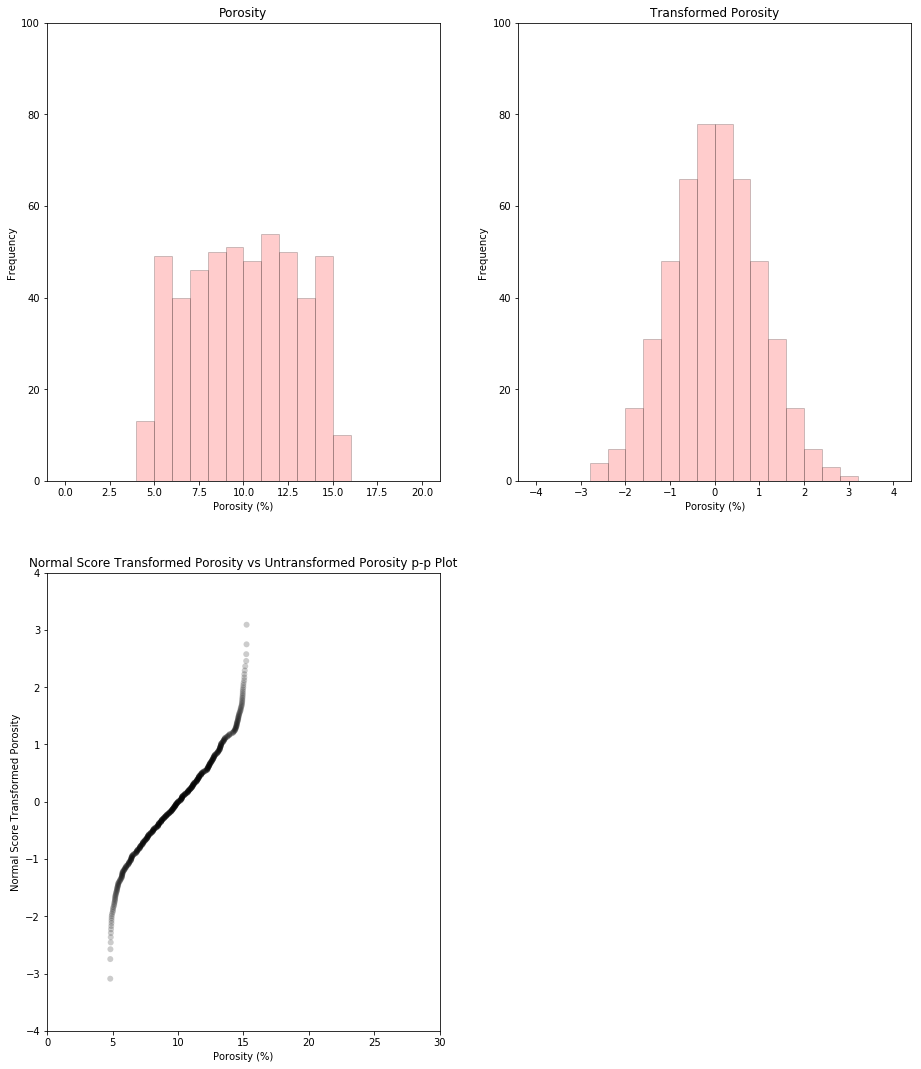

In [318]:
t = np.random.rand(500)
t = affine(t,10.0,3.0)
df = pd.DataFrame({'t':t})
ns, tab_vr, tab_ns = nscore(df,'t')

plt.subplot(221)
hist_st(t,0.0,20.0,log=False,cumul=False,bins=20,weights=None,xlabel="Porosity (%)",title="Porosity")
plt.ylim(0.0,100)

plt.subplot(222)
hist_st(ns,-4.0,4.0,log=False,cumul=False,bins=20,weights=None,xlabel="Porosity (%)",title="Transformed Porosity")
plt.ylim(0.0,100)

plt.subplot(223)
plt.scatter(tab_vr,tab_ns, c = "black", marker='o', alpha = 0.2, edgecolors = "none")
plt.xlabel('Porosity (%)')
plt.ylabel('Normal Score Transformed Porosity')
plt.title('Normal Score Transformed Porosity vs Untransformed Porosity p-p Plot')
plt.ylim(-4,4)
plt.xlim(0,30)

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=3.5, wspace=0.2, hspace=0.2)
plt.show()

Here's an example with data weights applied.  For simple demosntration, I use random weights.  This would typical be accomplished with declustering weights.

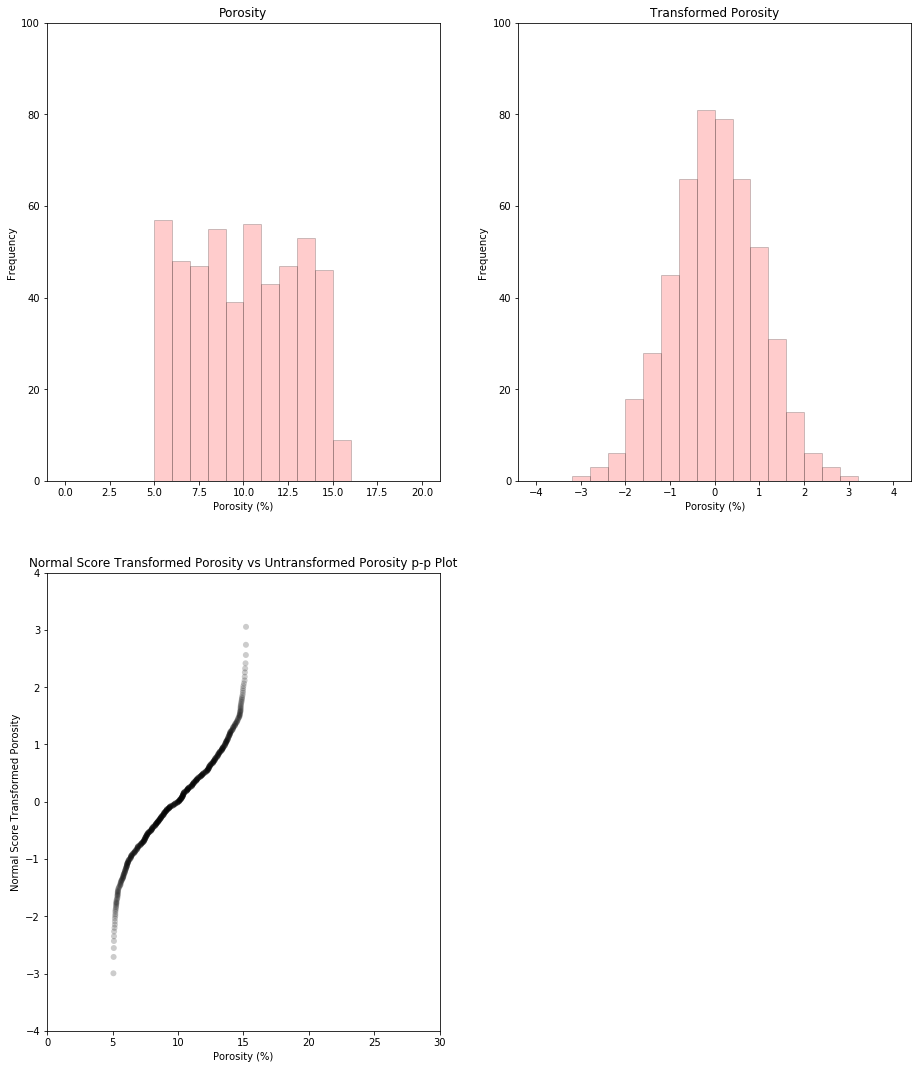

In [322]:
t = np.random.rand(500)
t = affine(t,10.0,3.0)
wts = np.random.rand(500)
wts = affine(wts,1.0,0.25)
df = pd.DataFrame({'t':t,'wts':wts})
ns, tab_vr, tab_ns = nscore(df,'t','wts')

plt.subplot(221)
hist_st(t,0.0,20.0,log=False,cumul=False,bins=20,weights=None,xlabel="Porosity (%)",title="Porosity")
plt.ylim(0.0,100)

plt.subplot(222)
hist_st(ns,-4.0,4.0,log=False,cumul=False,bins=20,weights=None,xlabel="Porosity (%)",title="Transformed Porosity")
plt.ylim(0.0,100)

plt.subplot(223)
plt.scatter(tab_vr,tab_ns, c = "black", marker='o', alpha = 0.2, edgecolors = "none")
plt.xlabel('Porosity (%)')
plt.ylabel('Normal Score Transformed Porosity')
plt.title('Normal Score Transformed Porosity vs Untransformed Porosity p-p Plot')
plt.ylim(-4,4)
plt.xlim(0,30)

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=3.5, wspace=0.2, hspace=0.2)
plt.show()

Here's an example with reference distribution.  Care should be taken with this method and reference distributions as there is not tail extrapolation to hand values outside the range of the reference distribution.

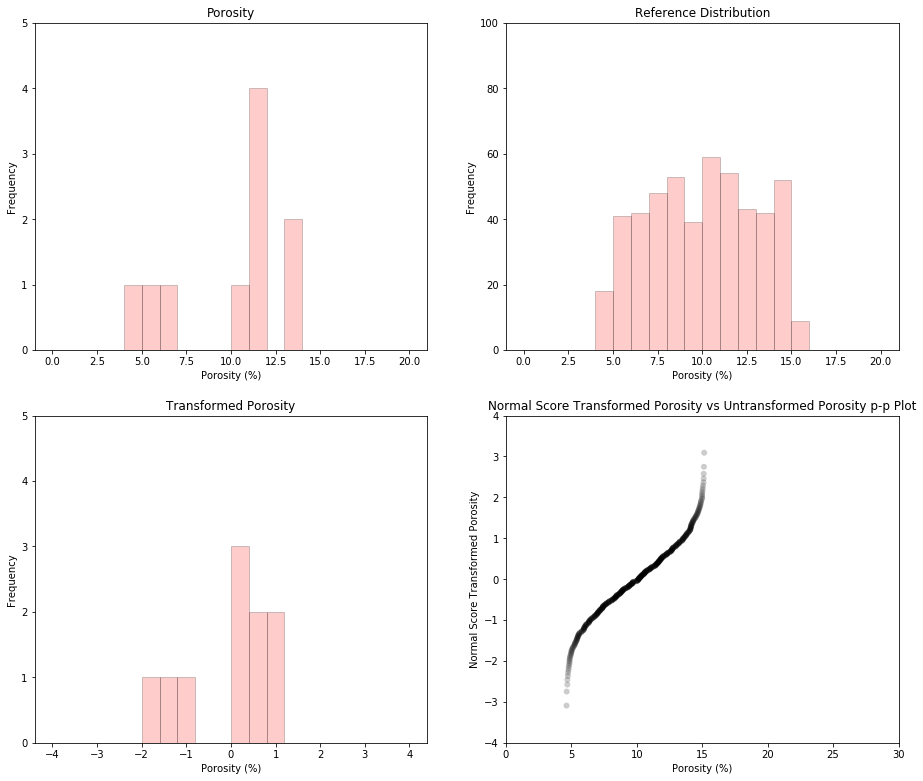

In [325]:
ref = np.random.rand(500)
ref = affine(ref,10.0,3.0)

df_ref = pd.DataFrame({'ref':ref})
t = np.random.rand(10)
t = affine(t,10,3.0)
df_t = pd.DataFrame({'t':t})

ns, tab_vr, tab_ns = nscore(df_t,'t',wcol=0,ismooth=1,dfsmooth=df_ref,smcol='ref',smwcol=0)

plt.subplot(221)
hist_st(t,0.0,20.0,log=False,cumul=False,bins=20,weights=None,xlabel="Porosity (%)",title="Porosity")
plt.ylim(0.0,5)

plt.subplot(222)
hist_st(ref,0.0,20.0,log=False,cumul=False,bins=20,weights=None,xlabel="Porosity (%)",title="Reference Distribution")
plt.ylim(0.0,100)

plt.subplot(223)
hist_st(ns,-4.0,4.0,log=False,cumul=False,bins=20,weights=None,xlabel="Porosity (%)",title="Transformed Porosity")
plt.ylim(0.0,5)

plt.subplot(224)
plt.scatter(tab_vr,tab_ns, c = "black", marker='o', alpha = 0.2, edgecolors = "none")
plt.xlabel('Porosity (%)')
plt.ylabel('Normal Score Transformed Porosity')
plt.title('Normal Score Transformed Porosity vs Untransformed Porosity p-p Plot')
plt.ylim(-4,4)
plt.xlim(0,30)

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=2.5, wspace=0.2, hspace=0.2)
plt.show()

I hope you find this code and demonstration useful. I'm always happy to discuss geostatistics, statistical modeling, uncertainty modeling and machine learning,

*Michael*

**Michael Pyrcz**, Ph.D., P.Eng. Associate Professor The Hildebrand Department of Petroleum and Geosystems Engineering, Bureau of Economic Geology, The Jackson School of Geosciences, The University of Texas at Austin
On Twitter I'm the **GeostatsGuy** and on YouTube my lectures are on the channel, **GeostatsGuy Lectures**.